In [2]:
from utils import Utils
import scipy

In [3]:
kattai_freqs = {
 "0_75": 246.94,
 "1": 261.63,
 "1_5": 277.18,
 '2': 293.66,
 '2_5': 311.13,
 '3': 329.63,
 '4': 349.23,
 '4_5': 369.99,
 '5': 392.0,
 '5_5': 415.3,
 '6': 440.0,
 '6_5': 466.16,
 '7': 493.88
}


#kattai_freqs

In [4]:

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean


def load_audio(file_path, sr=22050):
    """
    Load an audio file.

    Parameters:
    - file_path: Path to the audio file.
    - sr: Sampling rate.

    Returns:
    - y: Audio time series.
    - sr: Sampling rate.
    """
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    return y, sr


def extract_pitch_histogram(y, sr, bins=128, hist_range=(0, 128)):
    """
    Extract a pitch histogram using HPSS and YIN algorithm.

    Parameters:
    - y: Audio time series.
    - sr: Sampling rate.
    - bins: Number of histogram bins.
    - hist_range: The lower and upper range of the bins.

    Returns:
    - histogram: Normalized pitch histogram.
    """
    # Separate harmonic and percussive components
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    # Use YIN for fundamental frequency estimation
    f0 = librosa.yin(y_harmonic, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0 = f0[f0 > 0]  # Remove unvoiced frames

    if len(f0) == 0:
        return np.zeros(bins)

    # Convert frequencies to MIDI notes
    midi_notes = librosa.hz_to_midi(f0)
    histogram, _ = np.histogram(midi_notes, bins=bins, range=hist_range)
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram)  # Normalize

    return histogram


def load_shruthis(shruthis_dir):
    """
    Load and process tanpura (Shruti) reference audios.

    Parameters:
    - shruthis_dir: Directory containing shruti subdirectories.

    Returns:
    - shruti_features: Dictionary mapping frequency to pitch histogram.
    """
    shruti_features = {}
    for kattai_str, freq in kattai_freqs.items():
        # Convert kattai key from float to string with underscore
        kattai_dir = os.path.join(shruthis_dir, f'kattai{kattai_str}')
        audio_file = os.path.join(kattai_dir, f'kattai{kattai_str}_audio_1.wav')

        if not os.path.exists(audio_file):
            print(f"Warning: {audio_file} does not exist. Skipping.")
            continue

        y, sr = load_audio(audio_file)
        histogram = extract_pitch_histogram(y, sr)
        shruti_features[freq] = histogram

        print(f"Loaded Shruti for Kattai {kattai_str} ({freq} Hz)")

    return shruti_features


def process_test_audio(test_audio_path, shruti_features):
    """
    Process the test audio and compute similarity with shruti references.

    Parameters:
    - test_audio_path: Path to the test audio file.
    - shruti_features: Dictionary mapping frequency to pitch histogram.

    Returns:
    - similarity_scores: Dictionary mapping frequency to similarity score.
    """
    y, sr = load_audio(test_audio_path)
    test_histogram = extract_pitch_histogram(y, sr)

    similarity_scores = {}
    for freq, shruti_hist in shruti_features.items():
        distance = euclidean(test_histogram, shruti_hist)
        similarity_scores[freq] = distance

        print(f"Distance with {freq} Hz Shruti: {distance:.4f}")

    return similarity_scores


def predict_tonic(similarity_scores):
    """
    Predict the tonic frequency based on similarity scores.

    Parameters:
    - similarity_scores: Dictionary mapping frequency to similarity score.

    Returns:
    - predicted_freq: Predicted tonic frequency.
    - sorted_scores: List of frequencies sorted by similarity.
    """
    sorted_scores = sorted(similarity_scores.items(), key=lambda item: item[1])
    predicted_freq = sorted_scores[0][0]
    return predicted_freq, sorted_scores


def plot_similarity(similarity_scores):
    """
    Plot similarity scores for visualization.

    Parameters:
    - similarity_scores: Dictionary mapping frequency to similarity score.
    """
    freqs = list(similarity_scores.keys())
    scores = list(similarity_scores.values())

    plt.figure(figsize=(12, 6))
    plt.bar(freqs, scores, color='skyblue')
    plt.xlabel('Tonic Frequency (Hz)')
    plt.ylabel('Euclidean Distance')
    plt.title('Distance Scores between Test Audio and Shruti References')
    plt.xticks(freqs, rotation=45)
    plt.tight_layout()
    plt.show()

shruti_features = load_shruthis('shruthis')

Loaded Shruti for Kattai 0_75 (246.94 Hz)
Loaded Shruti for Kattai 1 (261.63 Hz)
Loaded Shruti for Kattai 1_5 (277.18 Hz)
Loaded Shruti for Kattai 2 (293.66 Hz)
Loaded Shruti for Kattai 2_5 (311.13 Hz)
Loaded Shruti for Kattai 3 (329.63 Hz)
Loaded Shruti for Kattai 4 (349.23 Hz)
Loaded Shruti for Kattai 4_5 (369.99 Hz)
Loaded Shruti for Kattai 5 (392.0 Hz)
Loaded Shruti for Kattai 5_5 (415.3 Hz)
Loaded Shruti for Kattai 6 (440.0 Hz)
Loaded Shruti for Kattai 6_5 (466.16 Hz)
Loaded Shruti for Kattai 7 (493.88 Hz)


Distance with 246.94 Hz Shruti: 0.7090
Distance with 261.63 Hz Shruti: 0.7678
Distance with 277.18 Hz Shruti: 0.7844
Distance with 293.66 Hz Shruti: 0.7207
Distance with 311.13 Hz Shruti: 0.5828
Distance with 329.63 Hz Shruti: 0.5154
Distance with 349.23 Hz Shruti: 0.8500
Distance with 369.99 Hz Shruti: 0.8413
Distance with 392.0 Hz Shruti: 0.8486
Distance with 415.3 Hz Shruti: 0.8506
Distance with 440.0 Hz Shruti: 0.8534
Distance with 466.16 Hz Shruti: 0.7338
Distance with 493.88 Hz Shruti: 0.7533

Predicted Tonic Frequency: 329.63 Hz


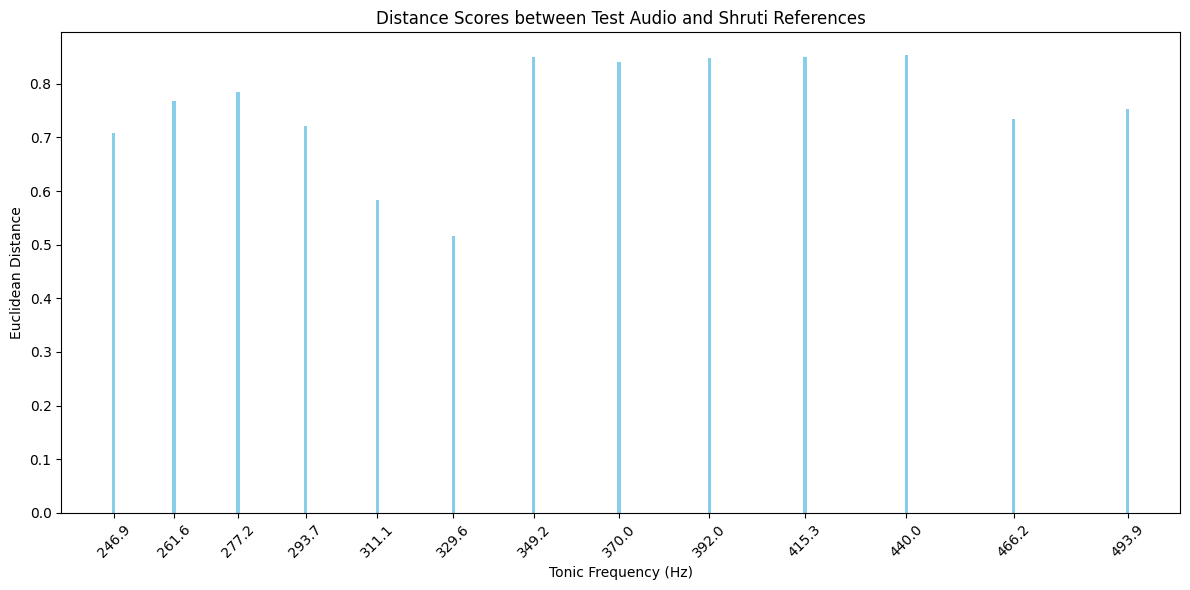

Predicted Tonic Note: E


In [5]:
shruthis_dir = 'shruthis'  
test_audio_path = 'audios/muthai_tharu.wav'  

if not os.path.exists(shruthis_dir):
    print(f"Error: {shruthis_dir} directory does not exist.")
    exit(1)

if not os.path.exists(test_audio_path):
    print(f"Error: {test_audio_path} does not exist.")
    exit(1)


if not shruti_features:
    print("Error: No Shruti references loaded. Exiting.")
    exit(1)

similarity_scores = process_test_audio(test_audio_path, shruti_features)


predicted_freq, sorted_scores = predict_tonic(similarity_scores)
print(f"\nPredicted Tonic Frequency: {predicted_freq} Hz")


plot_similarity(similarity_scores)

note = librosa.hz_to_note(predicted_freq, octave=False)
print(f"Predicted Tonic Note: {note}")


In [6]:
# Define Swaras and their frequency ratios relative to Adhara Shadja (Sa)
swaras_ratios = {
    'Sa': 1.0,            # Adhara Shadja
    'Ri1': 16/15,         # Shuddha Rishabha
    'Ri2/Ga1': 9/8,       # Chatushruti Rishabha / Shuddha Gandhara
    'Ri3/Ga2': 6/5,       # Shatshruti Rishabha / Sadharana Gandhara
    'Ga3': 5/4,           # Anthara Gandhara
    'Ma1': 4/3,           # Shuddha Madhyama
    'Ma2': 7/5,           # Prati Madhyama
    'Pa': 3/2,            # Panchama
    'Da1': 8/5,           # Shuddha Dhaivata
    'Da2/Ni1': 27/16,     # Chatushruti Dhaivata / Shuddha Nishada
    'Da3/Ni2': 9/5,       # Shatshruti Dhaivata / Kaishiki Nishada
    'Ni3': 15/8,          # Kakali Nishada
    'SA': 2.0             # Tara Shadja (octave)
}


In [7]:
def calculate_swara_frequencies(sa_freq):
    """
    Calculate the absolute frequencies of all Swaras based on the given Sa frequency.

    Parameters:
    - sa_freq: Frequency of Adhara Shadja (Sa) in Hz.

    Returns:
    - swaras_freq: Dictionary mapping each Swara to its absolute frequency in Hz.
    """
    swaras_freq = {}
    for swara, ratio in swaras_ratios.items():
        swaras_freq[swara] = sa_freq * ratio
    return swaras_freq


In [ ]:
def map_frequency_to_swara(freq, swaras_freq):
    """
    Map a frequency to the nearest Swara based on the provided Swara frequencies.

    Parameters:
    - freq: Detected frequency in Hz.
    - swaras_freq: Dictionary mapping each Swara to its absolute frequency in Hz.

    Returns:
    - nearest_swara: The Swara closest to the detected frequency.
    - swara_freq: The frequency of the nearest Swara.
    - difference: The difference between the detected frequency and the Swara frequency.
    """
    nearest_swara = None
    swara_freq = 0
    min_diff = float('inf')
    
    for swara, s_freq in swaras_freq.items():
        diff = abs(freq - s_freq)
        if diff < min_diff:
            min_diff = diff
            nearest_swara = swara
            swara_freq = s_freq
            
    return nearest_swara, swara_freq, min_diff


In [ ]:
# Existing code continuation...

similarity_scores = process_test_audio(test_audio_path, shruti_features)

predicted_freq, sorted_scores = predict_tonic(similarity_scores)
print(f"\nPredicted Tonic Frequency: {predicted_freq} Hz")

plot_similarity(similarity_scores)

# Existing note conversion
note = librosa.hz_to_note(predicted_freq, octave=False)
print(f"Predicted Tonic Note: {note}")

# --- Added Code Starts Here ---

# Step 1: Calculate Swara Frequencies based on predicted Sa frequency
swaras_freq = calculate_swara_frequencies(predicted_freq)

# Step 2: Map the predicted frequency to the nearest Swara
nearest_swara, swara_freq, difference = map_frequency_to_swara(predicted_freq, swaras_freq)

print(f"Mapped Swara: {nearest_swara}")
print(f"Swara Frequency: {swara_freq:.2f} Hz")
print(f"Difference: {difference:.2f} Hz")

# Optional: Display all Swaras with their frequencies
print("\nSwaras Frequencies:")
for swara, freq in swaras_freq.items():
    print(f"{swara}: {freq:.2f} Hz")
    
# Optionally, visualize the Swaras frequencies on the similarity plot
plt.figure(figsize=(12, 6))
plt.bar(freqs, scores, color='skyblue', label='Similarity Scores')

# Plot Swara frequencies
for swara, freq in swaras_freq.items():
    plt.axvline(x=freq, color='red', linestyle='--', alpha=0.5)
    plt.text(freq, max(scores)*0.9, swara, rotation=90, verticalalignment='center', color='red')

plt.xlabel('Tonic Frequency (Hz)')
plt.ylabel('Euclidean Distance')
plt.title('Distance Scores between Test Audio and Shruti References with Swaras')
plt.xticks(freqs, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Added Code Ends Here ---
